[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zhimingkuang/Harvard-AM-115/blob/main/13_traffic/advect1d.ipynb)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import IPython.display as IP

### A demo for solving 1D advection equation
A Gaussian bump will cycle through and come back to its original position.

This example illustrates the CFL number, the upwind scheme and its diffusive nature. 

In [2]:
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['mathtext.default'] = 'regular'
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20

In [3]:
# Define the domain
nx = 100
x = np.zeros((nx,), dtype=np.float32())
x[1:] = np.linspace(0,1,nx-1)
# 0 and nx will be used as ghost cells

# Set upwinding scheme
method = 5
case = method
# 1: upwind
# 2: downwind
# 3: centered differencing
# 4: Lax-Wendroff
# 5: Flux limiter (Monotonized central difference or MC limiter)

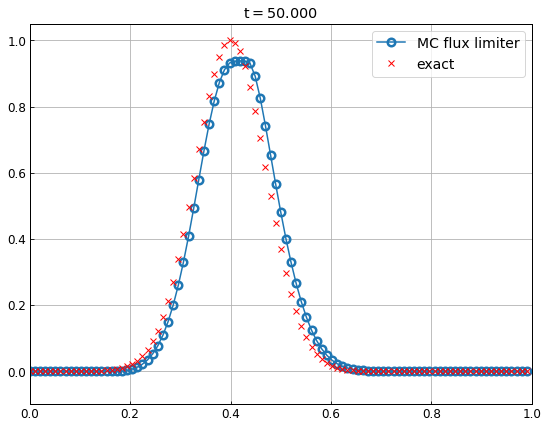

In [4]:
# Initial condition
y0 = np.exp(-((x-0.4)/0.1)**2)
# y0[:] = 0
# y0[4:10] = 1
previous_y = y0.copy()
y = np.zeros(np.shape(previous_y), dtype=np.float32())

# Advection speed
c = 0.1

# Set grid spacing and time step
dx = x[2] - x[1]
dt = dx / c * 0.7

# Set total simulation time
tend = 50
nt = int(np.floor(tend/dt))

fig, ax = plt.subplots(1,1,figsize=(9,7))

for it in range(nt+1):
    # Ghost cells for periodic boundary conditions
    previous_y[0] = previous_y[nx-2]
    previous_y[nx-1] = previous_y[1]
    
    # Use flux limiter
    if method == 5:
        theta = np.zeros((nx-1,), dtype=np.float32())
        phi = np.zeros((nx-1,), dtype=np.float32())
        for i in range(1, nx-1):
            # Add a small value to prevent division by zero error
            # Alternative way is to decrease grid spacing or time step
            theta[i] = (previous_y[i-1] - previous_y[i]) / (previous_y[i] - previous_y[i+1] + 1e-12)
            phi[i] = max( 0, min( min( (1+theta[i])/2, 2), 2*theta[i] ) )
            
    for i in range(1, nx-1): 
        if case == 1: 
            # Upwind
            method_name = 'upwind'
            flux_in = previous_y[i-1] * c  
            flux_out = previous_y[i] * c
        elif case == 2: 
            # Downwind
            method_name = 'downwind'
            flux_in = previous_y[i] * c  
            flux_out = previous_y[i+1] * c
        elif case == 3:
            # Use an average to compute the fluxes
            method_name = 'average'
            flux_in = (previous_y[i-1] + previous_y[i])/2. * c
            flux_out = (previous_y[i] + previous_y[i+1])/2. * c
        elif case == 4:
            # Lax-Wendroff
            method_name = 'Lax–Wendroff'
            flux_in = (previous_y[i-1] + previous_y[i])/2. * c + (dt/dx)*(c**2)/2. * (previous_y[i-1] - previous_y[i])
            flux_out = (previous_y[i] + previous_y[i+1])/2. * c + (dt/dx)*(c**2)/2. * (previous_y[i] - previous_y[i+1])
        elif case == 5: 
            # MC flux limiter
            method_name = 'MC flux limiter'
            cflm = c*dt/dx # cflm and cflp could be different for variable wave speeds.
            cflp = c*dt/dx
            flux_in = previous_y[i-1] * c + 0.5*cflm*(dx/dt)*(1-cflm)*phi[i-1] * (previous_y[i] - previous_y[i-1])
            flux_out = previous_y[i] * c + 0.5*cflp*(dx/dt)*(1-cflp)*phi[i] * (previous_y[i+1] - previous_y[i])
        else: 
            print('Unknown method')
        y[i] = previous_y[i] + (flux_in-flux_out)*dt/dx
    previous_y=y.copy()
    
    if it%np.floor(nt/50.) == 0: 
        ax.cla()
        ax.plot(x[1:nx-1], y[1:nx-1], '-o', linewidth=1.5, mfc='none', ms=7.5, mew=2.5, label=method_name)
        ax.plot((x[1:nx-1] + c*it*dt)%1, y0[1:nx-1], 'x', color='red', label='exact')
        ax.grid(True)
        ax.set_xlim([-0.0, 1.0])
        ax.set_ylim([-0.1, 1.05])
        ax.set_title(r'$t = %.3f$' % (it*dt))
        ax.legend(loc='upper right')
        IP.display(fig)
        IP.clear_output(wait = True)
        plt.pause(0.2)